In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Using pandas to load the CSV file into a DataFrame.
# Inspecting the first few rows to understand the structure and content.
df = pd.read_csv('stop_tb_data2.csv')
print(df.head())



  country_name  year iso3_code  fragility  fragilityindex g_whoregion  \
0       Zambia  2000       ZMB  Neighbour            87.2         AFR   
1       Zambia  2001       ZMB  Neighbour            87.2         AFR   
2       Zambia  2002       ZMB  Neighbour            87.2         AFR   
3       Zambia  2003       ZMB  Neighbour            87.2         AFR   
4       Zambia  2004       ZMB  Neighbour            87.2         AFR   

   gendertool gf_eligible_2016 gf_eligible_2018    globalplangroup  ...  \
0         NaN              Yes              Yes  High TB-HIV, SADC  ...   
1         NaN              Yes              Yes  High TB-HIV, SADC  ...   
2         NaN              Yes              Yes  High TB-HIV, SADC  ...   
3         NaN              Yes              Yes  High TB-HIV, SADC  ...   
4         NaN              Yes              Yes  High TB-HIV, SADC  ...   

   used_2021_defs_flg xdr xdr_coh xdr_died  xdr_fail xdr_lost  xdr_succ xpert  \
0                 NaN NaN    

In [2]:
# Checking the number of missing values per column
missing_values_count = df.isnull().sum()

# Checking the percentage of missing values per column
missing_values_percentage = df.isnull().mean() * 100

# Print results
print(missing_values_count)
print(missing_values_percentage)


country_name       0
year               0
iso3_code          0
fragility          0
fragilityindex     0
                  ..
xdr_lost          20
xdr_succ          20
xpert             23
xpert_eqa         23
xpert_etrans      23
Length: 934, dtype: int64
country_name       0.000000
year               0.000000
iso3_code          0.000000
fragility          0.000000
fragilityindex     0.000000
                    ...    
xdr_lost          71.428571
xdr_succ          71.428571
xpert             82.142857
xpert_eqa         82.142857
xpert_etrans      82.142857
Length: 934, dtype: float64


In [3]:
# Dropping columns with more than 50% missing values


df = df.dropna(thresh=len(df) * 0.5, axis=1)

# Filling missing values with median for numerical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())


In [4]:
# Checking the number of missing values per column again
missing_values_count = df.isnull().sum()

# Checking the percentage of missing values per column again
missing_values_percentage = df.isnull().mean() * 100

# Print results
print(missing_values_count)
print(missing_values_percentage)


country_name            0
year                    0
iso3_code               0
fragility               0
fragilityindex          0
                       ..
e_tbhiv_prct_hi         0
e_tbhiv_prct_lo         0
new_ep                  0
new_labconf             0
notified_dr_tb_cases    0
Length: 96, dtype: int64
country_name            0.0
year                    0.0
iso3_code               0.0
fragility               0.0
fragilityindex          0.0
                       ... 
e_tbhiv_prct_hi         0.0
e_tbhiv_prct_lo         0.0
new_ep                  0.0
new_labconf             0.0
notified_dr_tb_cases    0.0
Length: 96, dtype: float64


In [5]:
# Display the first few rows of the dataframe
print(df.head())

# Display a summary of the dataframe to check data types and non-null counts
print(df.info())


  country_name  year iso3_code  fragility  fragilityindex g_whoregion  \
0       Zambia  2000       ZMB  Neighbour            87.2         AFR   
1       Zambia  2001       ZMB  Neighbour            87.2         AFR   
2       Zambia  2002       ZMB  Neighbour            87.2         AFR   
3       Zambia  2003       ZMB  Neighbour            87.2         AFR   
4       Zambia  2004       ZMB  Neighbour            87.2         AFR   

  gf_eligible_2016 gf_eligible_2018    globalplangroup  \
0              Yes              Yes  High TB-HIV, SADC   
1              Yes              Yes  High TB-HIV, SADC   
2              Yes              Yes  High TB-HIV, SADC   
3              Yes              Yes  High TB-HIV, SADC   
4              Yes              Yes  High TB-HIV, SADC   

   gnipercapita_2018_atlas  ... e_mort_tbhiv_num e_mort_tbhiv_num_hi  \
0                     1430  ...          19000.0             29000.0   
1                     1430  ...          19000.0             29000.0

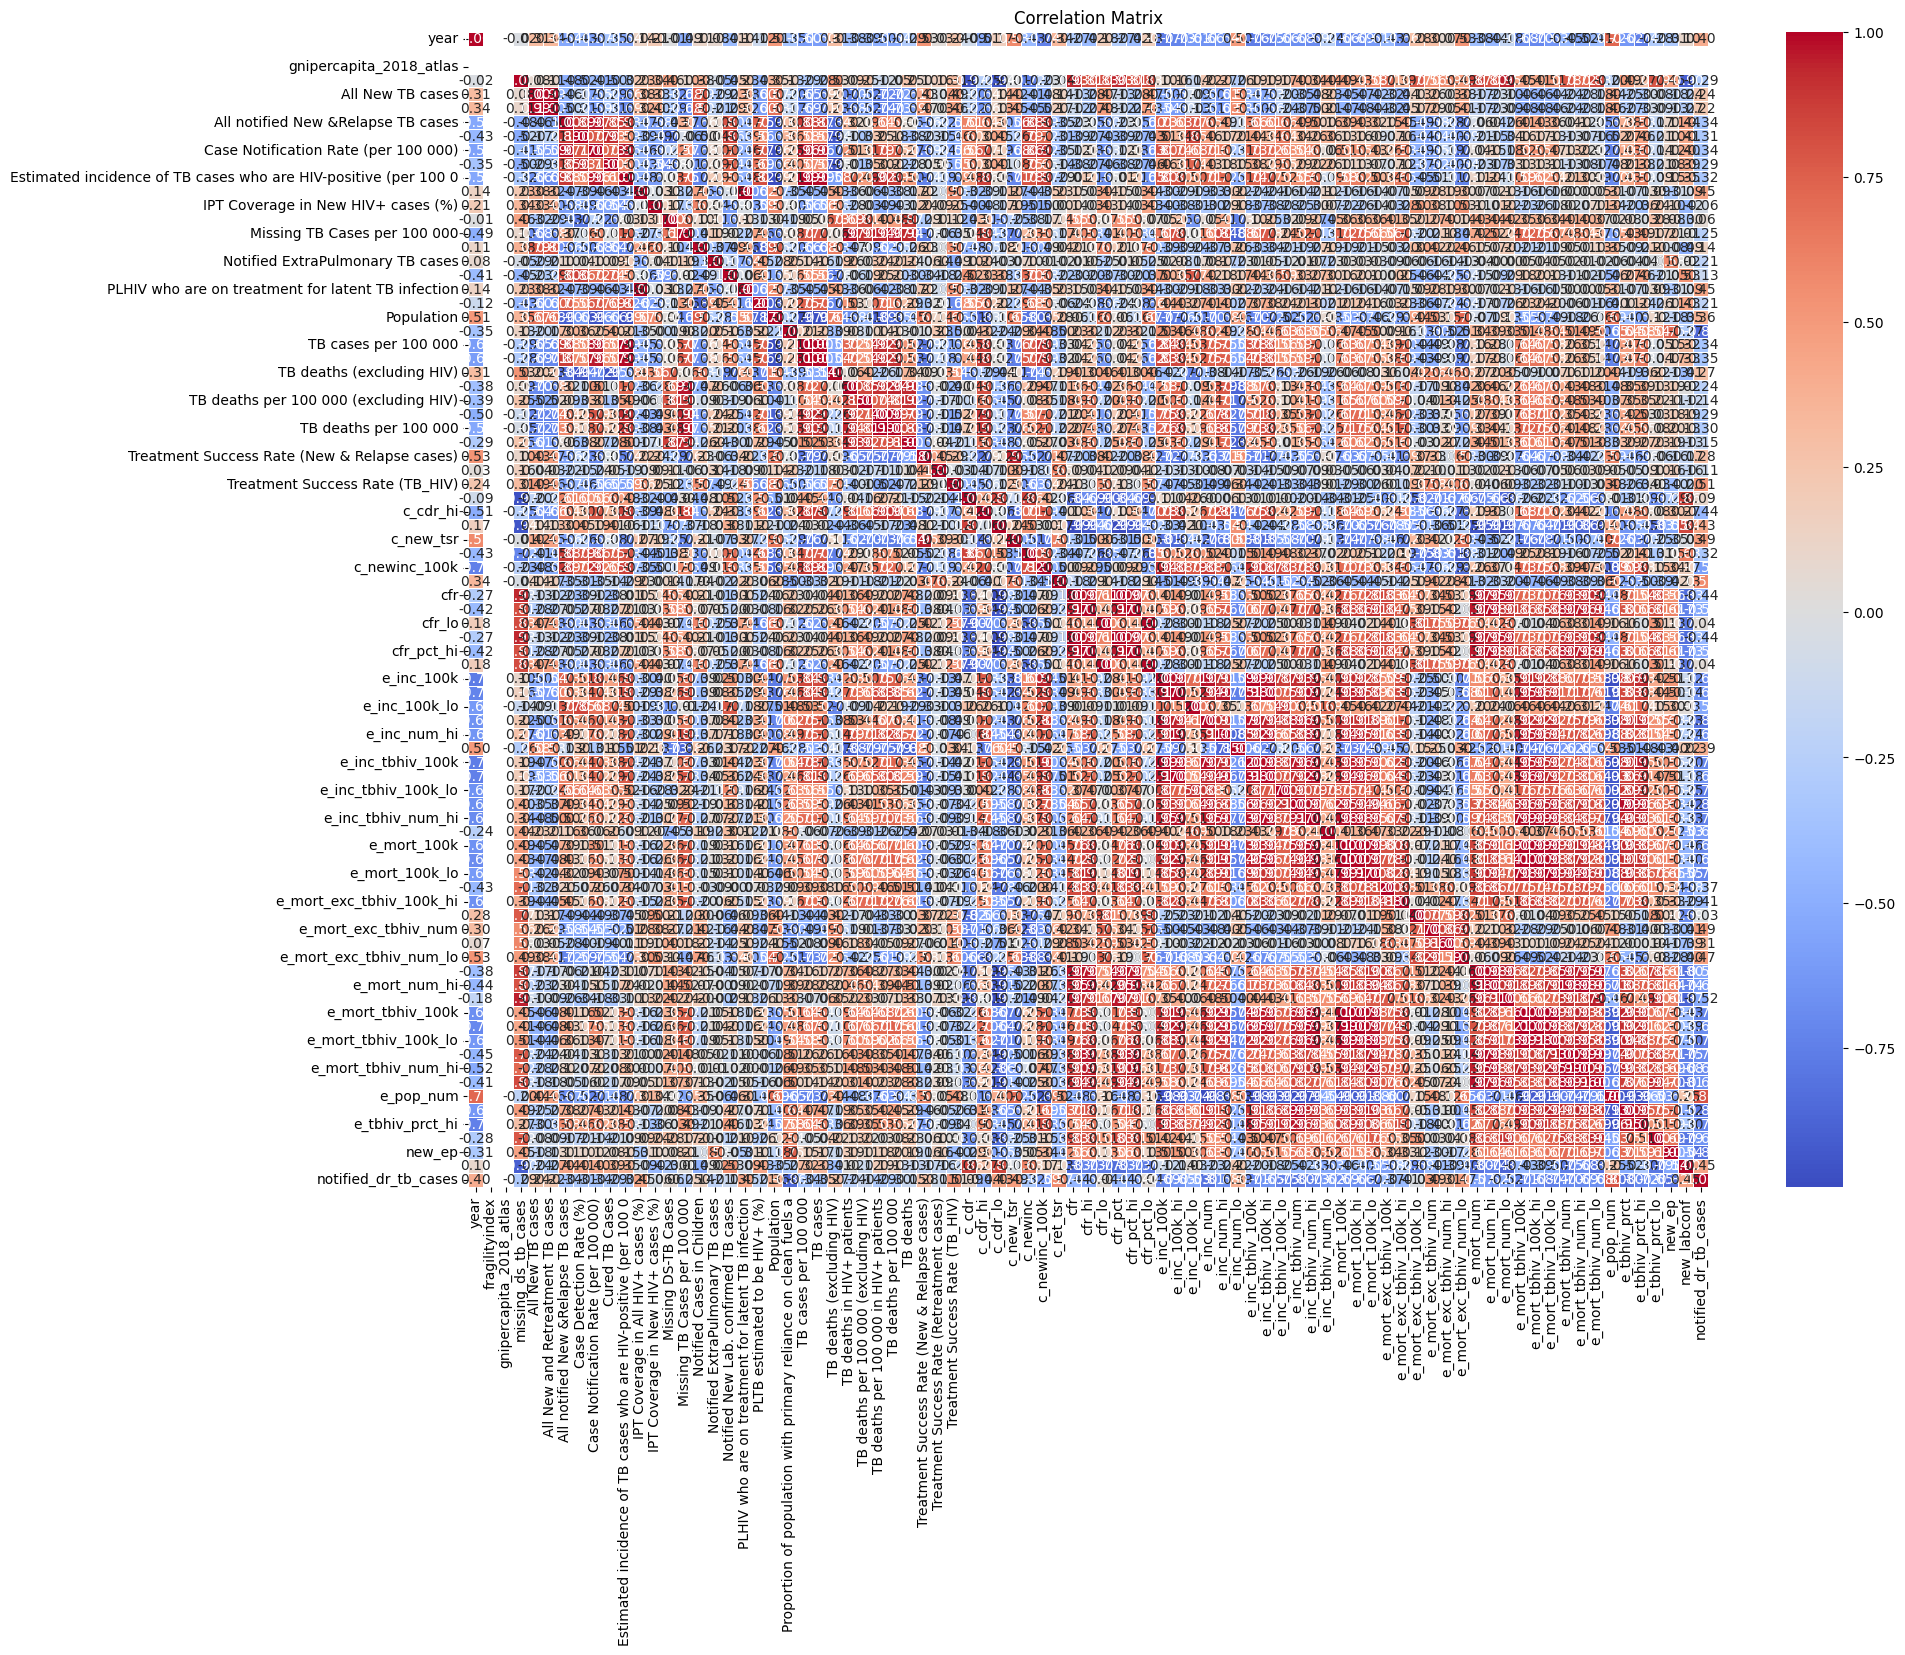

In [6]:
# Drop non-numeric or irrelevant columns
df_filtered = df.drop(columns=['country_name', 'iso3_code', 'g_whoregion'])

# Convert remaining categorical columns to numeric using one-hot encoding
df_numeric = pd.get_dummies(df_filtered, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [7]:
# List of TB incidence columns
tb_incidence_columns = ['e_inc_100k', 'e_inc_num', 'e_inc_tbhiv_100k', 'e_inc_tbhiv_num', 'TB cases per 100 000', 'TB cases']

# Looping through each column and get top correlations
for col in tb_incidence_columns:
    print(f"Top correlations for {col}:")
    tb_corr = correlation_matrix[col].drop(col)
    
    # Sort by absolute correlation values
    sorted_tb_corr = tb_corr.abs().sort_values(ascending=False)
    
    # Display top 30 positive and negative correlations
    print(sorted_tb_corr.head(30))  # Top 30 correlations
    print("\n")


Top correlations for e_inc_100k:
e_inc_tbhiv_100k        0.992599
e_pop_num               0.975399
e_inc_tbhiv_100k_hi     0.974474
e_inc_100k_hi           0.972050
e_inc_num               0.970178
e_inc_tbhiv_num_hi      0.946487
c_newinc_100k           0.942592
e_tbhiv_prct_hi         0.933038
e_inc_tbhiv_num         0.925788
e_mort_tbhiv_100k_hi    0.921428
e_mort_100k_hi          0.915390
e_mort_tbhiv_100k       0.912180
e_inc_num_hi            0.906484
e_mort_100k             0.898005
e_mort_tbhiv_100k_lo    0.882696
e_inc_tbhiv_100k_lo     0.869882
e_tbhiv_prct            0.862590
e_mort_100k_lo          0.853872
TB cases per 100 000    0.838076
TB cases                0.833878
Name: e_inc_100k, dtype: float64


Top correlations for e_inc_num:
e_pop_num               0.983607
e_inc_tbhiv_100k        0.971954
e_inc_100k              0.970178
e_inc_tbhiv_num         0.956637
e_inc_tbhiv_num_hi      0.954083
e_inc_100k_hi           0.941441
e_inc_tbhiv_100k_hi     0.941398
e_mort_tb